In [1]:
# visualizing heatmaps of class activation in an image.

In [2]:
# useful for understanding which parts of a given image led a convnet
# to its final classification decision.

In [3]:
# This general category of techniques is called class activation map (CAM) visualization,
# and it consists of producing heatmaps of class activation over input images.
# A class activation heatmap is a 2D grid of scores associated with a specific output class,
# computed for every location in any input image,
# indicating how important each location is with respect to the class under consideration.

In [4]:
# The specific implementation you'll use is the one described in 
# "Grad-CAM": Visual Explanations from Deep Networks via Gradient-based Localization."
# It's very simple: it consists of taking the output feature map of a convolution layer,
# given an input image, and weighing every channel in that feature map
# by the gradient of the class with respect to the channel.

In [5]:
import tensorflow as tf


tf.compat.v1.disable_eager_execution()

In [6]:
from keras.applications.vgg16 import VGG16


model = VGG16(weights='imagenet')

2022-08-02 13:21:19.079885: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-02 13:21:19.083375: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-08-02 13:21:19.100082: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


In [7]:
from keras.utils import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np


img_path = 'dogs-vs-cats/train/cats/cat.1.jpg'
img = load_img(img_path, target_size=(224,224))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [8]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

/usr/lib/python3.10/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Predicted: [('n02123045', 'tabby', 0.49139673), ('n02123159', 'tiger_cat', 0.35423693), ('n02124075', 'Egyptian_cat', 0.073216744)]


In [9]:
np.argmax(preds[0])

281

In [10]:
# set up the Grad-CAM process

In [11]:
from keras import backend as K


cat_output = model.output[:, 281]
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(cat_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)

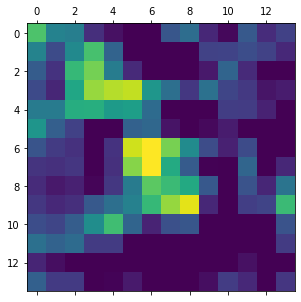

In [12]:
import matplotlib.pyplot as plt


heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [14]:
import cv2


img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('dogs-vs-cats/cam/cat_cam.jpg', superimposed_img)

True